# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,...,1.00,20,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,...,1.00,49,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,...,2.00,43,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,...,1.00,17,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,...,2.00,18,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,...,1.00,17,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,...,2.00,45,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,...,1.00,20,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,...,1.00,29,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
        - no more need for preprocessing
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

<AxesSubplot:>

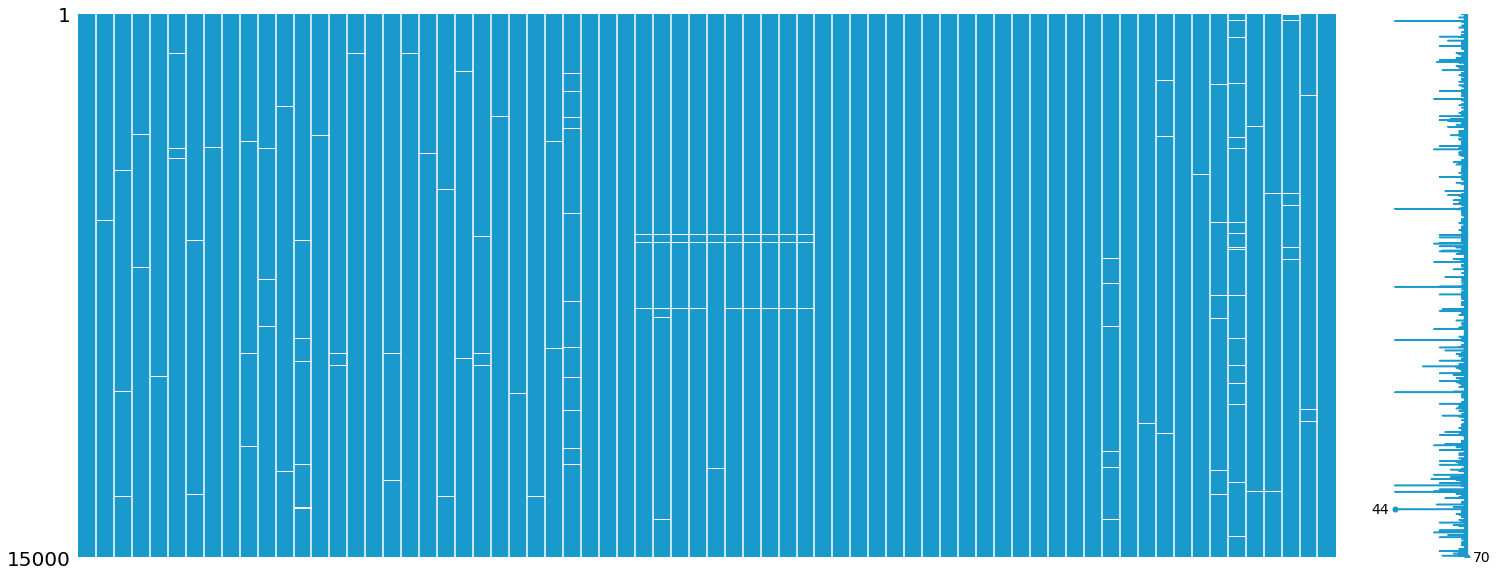

In [5]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3. Preprocessing
data -> processed_data (**15,000 x 69**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**

Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and imputate


In [11]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop : 'index'
processed_data = data.drop(['index'], axis=1).copy()

In [12]:
# Handling missing values : categorical variables
# fill na 
fill_cols = ['country', 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
processed_data[fill_cols] = processed_data[fill_cols].fillna(0)
processed_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,3.00,...,1.00,20,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,3.00,...,1.00,49,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,4.00,...,2.00,43,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,4.00,...,1.00,17,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,4.00,...,2.00,18,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,4.00,...,1.00,17,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,5.00,...,2.00,45,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,...,1.00,20,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,5.00,...,1.00,29,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


In [13]:
# Lable Encoding : 'country' 
from sklearn.preprocessing import LabelEncoder

# labeling the other countries as 1 
df_country = pd.DataFrame(data['country'].value_counts())
others = df_country[df_country['country']==1].index.values.tolist()
processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x in others else x)

le = LabelEncoder()
processed_data['country'] = le.fit_transform(list(processed_data['country']))   
print(le.classes_)

# save encoder
dump(le, open('labelencoder.pkl', 'wb'))

['0' '1' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR'
 'BHS' 'BIH' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'COL' 'CRI' 'CUW'
 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI'
 'FRA' 'FRO' 'FSM' 'GBR' 'GEO' 'GHA' 'GRC' 'GUM' 'HKG' 'HND' 'HRV' 'HUN'
 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KEN' 'KOR'
 'KWT' 'LBN' 'LTU' 'LUX' 'LVA' 'MAR' 'MEX' 'MKD' 'MLT' 'MOZ' 'MYS' 'NAM'
 'NGA' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRI'
 'PRT' 'PRY' 'QAT' 'ROU' 'RUS' 'SAU' 'SDN' 'SGP' 'SLV' 'SRB' 'SSD' 'SVK'
 'SVN' 'SWE' 'THA' 'TTO' 'TUN' 'TUR' 'TWN' 'UKR' 'URY' 'USA' 'VEN' 'VNM'
 'ZAF' 'ZMB']


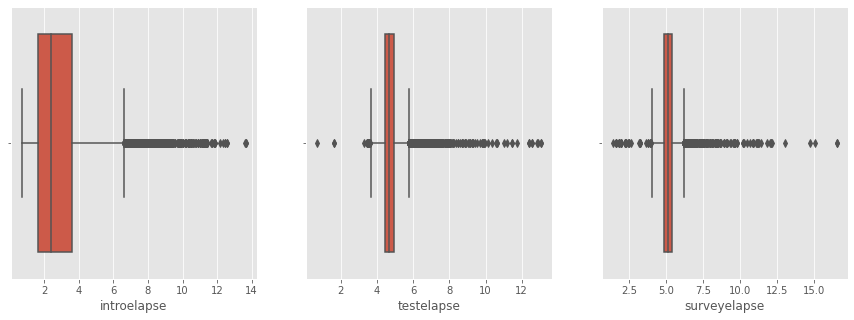

In [14]:
# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [15]:
# Ranging : 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.00    6824
1.00    5161
2.00    1493
3.00     822
4.00     459
5.00     202
6.00      28
9.00       7
7.00       3
8.00       1
Name: age, dtype: int64

<AxesSubplot:xlabel='familysize'>

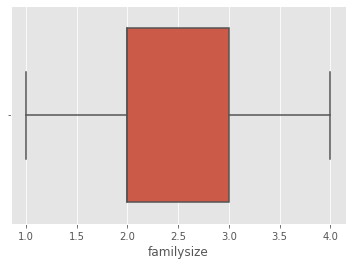

In [16]:
# Handling outlier : 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)

processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
sns.boxplot(x='familysize', data=processed_data)

In [17]:
processed_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,3.00,...,1.00,1.00,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,3.00,...,1.00,3.00,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,4.00,...,2.00,3.00,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,4.00,...,1.00,0.00,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,4.00,...,2.00,0.00,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,4.00,...,1.00,0.00,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,5.00,...,2.00,3.00,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,...,1.00,1.00,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,5.00,...,1.00,1.00,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 4. Data Split 
split data as train/valid

In [20]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,country,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,education,urban,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,3.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1.00,5.00,5.00,1.00,5.00,1.00,5.00,1.00,1.00,106,1.39,6.32,1.95,4.00,3.00,5.00,1.00,3.00,5.00,5.00,3.00,5.00,3.00,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,2.00,1,3.00,1.00,1.00,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,3.00,1.00,4.00,5.00,3.00,1.00,2.00,4.00,5.00,1.00,3.00,1.00,1.00,5.00,3.00,2.00,5.00,106,1.79,4.45,4.80,4.00,2.00,3.00,5.00,3.00,2.00,5.00,1.00,2.00,2.00,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,4.00,2,2.00,1.00,3.00,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,4.00,2.00,5.00,5.00,5.00,1.00,3.00,5.00,3.00,5.00,2.00,2.00,1.00,2.00,4.00,2.00,5.00,74,2.30,4.69,4.62,1.00,2.00,3.00,1.00,5.00,5.00,3.00,4.00,5.00,2.00,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,2.00,1,1.00,2.00,3.00,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,4.00,5.00,2.00,2.00,4.00,4.00,2.00,4.00,5.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,2.00,106,1.10,4.80,4.94,3.00,3.00,3.00,4.00,5.00,3.00,4.00,4.00,3.00,3.00,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,1,1.00,3,1.00,1.00,0.00,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,4.00,4.00,4.00,3.00,5.00,5.00,2.00,4.00,1.00,4.00,2.00,4.00,2.00,3.00,4.00,4.00,4.00,55,1.39,6.46,5.38,3.00,3.00,4.00,4.00,4.00,4.00,3.00,4.00,3.00,2.00,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1.00,2,2.00,2.00,0.00,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,4.00,1.00,4.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,4.00,1.00,2.00,5.00,4.00,2.00,4.00,106,2.56,4.64,5.09,2.00,2.00,4.00,3.00,3.00,5.00,3.00,3.00,3.00,3.00,1,1,1,1,1,0,0,0,0,1,0,1,1,1,1,1,2.00,2,2.00,1.00,0.00,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,5.00,1.00,4.00,4.00,4.00,2.00,5.00,5.00,4.00,1.00,5.00,3.00,4.00,4.00,5.00,4.00,5.00,106,3.47,4.67,5.19,3.00,2.00,4.00,5.00,4.00,3.00,4.00,1.00,2.00,2.00,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,4.00,1,2.00,2.00,3.00,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,5.00,2.00,5.00,5.00,3.00,4.00,106,2.89,4.64,5.13,1.00,3.00,2.00,5.00,1.00,5.00,3.00,3.00,1.00,1.00,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,1,2.00,2,2.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,5.00,3.00,5.00,4.00,4.00,1.00,5.00,4.00,5.00,5.00,2.00,5.00,3.00,5.00,3.00,3.00,5.00,106,2.71,4.23,4.70,1.00,1.00,3.00,5.00,4.00,5.00,5.00,4.00,2.00,1.00,1,1,1,1,1,0,0,1,0,1,0,1,1,1,1,1,3.00,2,2.00,1.00,1.00,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 5. AutoML 
using pycaret, outoML Library
- noramlize = 'zscore' 추가 
- country -> cardinality 작은 나라는 하나로 묶어서 미리 labeling 

---------------------------------------------------------------

- null values 
    - categorical -> 설문조사 컬럼 
    - numerical -> familysize 
    - imputation_type -> 'simple' or 'iterative'
- PCA, clustering 
    - 어느 변수에 적용할 수 있을까... caldinality가 높은 변수? 
    - religion, country,

In [18]:
from pycaret.classification import *
from time import time

In [45]:
# Setup Environment
cat_cols = input_data.iloc[:, 26:27].columns.values.tolist() + input_data.iloc[:, 56:60].columns.values.tolist() + input_data.iloc[:, 61:66].columns.values.tolist() + input_data.iloc[:, 67:68].columns.values.tolist()
num_cols = input_data.iloc[:, 27:30].columns.values.tolist() + input_data.iloc[:, 66:67].columns.values.tolist()
ord_cols = input_data.iloc[:, :26].columns.values.tolist() + input_data.iloc[:, 30:40].columns.values.tolist() + input_data.iloc[:, 60:61].columns.values.tolist()
ord_dict = {} 
for col in ord_cols :
    unique_list = input_data[col].unique()
    unique_list = sorted(unique_list[~pd.isnull(unique_list)])
    ord_dict[col] = unique_list

clf = setup(data = input_data, 
            #train_size = 0.8,
            test_data = input_data,
            target = 'nerdiness',
            ignore_features = ['country'],
            categorical_features = cat_cols,
            numeric_features = num_cols,
            ordinal_features = ord_dict,
            high_cardinality_features = ['religion'],
            high_cardinality_method = 'frequency',
            handle_unknown_categorical = True,
            data_split_stratify = True,
            normalize = False,
            #normalize_method = 'zscore', 
            imputation_type='simple',
            feature_selection = True,
            fold_shuffle=True,
            use_gpu = True,
            silent = True,
            session_id = 6315)
            # train_size = 0.7 is defualt!!! 

,Description,Value
0,session_id,6315
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(15000, 69)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,62
8,Ordinal Features,True
9,High Cardinality Features,True


## Comparing

In [27]:
# et, rf, cat, xgb, lgbm
top5 = compare_models(sort='AUC', n_select=5, fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7777,0.8708,0.8332,0.7805,0.8058,0.5466,0.5486,1.2050
rf,Random Forest Classifier,0.7827,0.8676,0.8368,0.7850,0.8099,0.5568,0.5586,0.9060
catboost,CatBoost Classifier,0.7596,0.8356,0.8165,0.7652,0.7899,0.5096,0.5113,6.6110
lightgbm,Light Gradient Boosting Machine,0.7528,0.8275,0.8114,0.7588,0.7841,0.4956,0.4973,0.1300
gbc,Gradient Boosting Classifier,0.7338,0.8088,0.7960,0.7420,0.7679,0.4566,0.4583,3.1810
ada,Ada Boost Classifier,0.7253,0.7972,0.7803,0.7384,0.7586,0.4403,0.4415,0.9030
lda,Linear Discriminant Analysis,0.7252,0.7969,0.8025,0.7287,0.7637,0.4371,0.4404,0.1190
knn,K Neighbors Classifier,0.6938,0.7459,0.7674,0.7055,0.7351,0.3737,0.3757,1.0970
nb,Naive Bayes,0.6803,0.7354,0.7513,0.6957,0.7222,0.3470,0.3487,0.0360
dt,Decision Tree Classifier,0.7085,0.7053,0.7353,0.7374,0.7363,0.4104,0.4105,0.1740


## Training top 5 models

In [46]:
total_models = []

In [47]:
cell_start_time = time()
model_et = create_model('et', fold = 10)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7887,0.8838,0.8412,0.7907,0.8152,0.5690,0.5705
1,0.7887,0.8856,0.8508,0.7856,0.8169,0.5680,0.5705
2,0.7700,0.8704,0.8315,0.7712,0.8002,0.5301,0.5322
3,0.7920,0.8878,0.8289,0.8019,0.8152,0.5775,0.5779
4,0.7933,0.8879,0.8386,0.7982,0.8179,0.5794,0.5803
5,0.7907,0.8800,0.8494,0.7886,0.8179,0.5726,0.5748
6,0.8087,0.9020,0.8518,0.8117,0.8313,0.6106,0.6116
7,0.7940,0.8823,0.8349,0.8012,0.8177,0.5811,0.5818
8,0.7900,0.8881,0.8349,0.7956,0.8148,0.5726,0.5735
9,0.7813,0.8711,0.8434,0.7795,0.8102,0.5533,0.5557


CELL RUN TIME :  15.608657836914062


In [48]:
cell_start_time = time()
model_rf = create_model('rf', fold = 10)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7887,0.8778,0.8448,0.7888,0.8158,0.5686,0.5705
1,0.8020,0.8879,0.8544,0.8014,0.8270,0.5961,0.5978
2,0.7780,0.8677,0.8400,0.7773,0.8074,0.5463,0.5486
3,0.7893,0.8869,0.8313,0.7968,0.8137,0.5716,0.5723
4,0.8040,0.8924,0.8542,0.8039,0.8283,0.6005,0.6020
5,0.7920,0.8747,0.8578,0.7859,0.8203,0.5746,0.5777
6,0.8033,0.9009,0.8566,0.8016,0.8282,0.5989,0.6007
7,0.7873,0.8741,0.8241,0.7981,0.8109,0.5681,0.5685
8,0.7927,0.8856,0.8386,0.7973,0.8174,0.5780,0.5789
9,0.7820,0.8678,0.8361,0.7842,0.8093,0.5555,0.5570


CELL RUN TIME :  12.234135627746582


In [49]:
cell_start_time = time()
model_cat = create_model('catboost', fold = 10)
total_models.append(model_cat)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7720,0.8367,0.8351,0.7720,0.8023,0.5340,0.5363
1,0.7640,0.8386,0.8291,0.7647,0.7956,0.5175,0.5199
2,0.7507,0.8265,0.8183,0.7530,0.7843,0.4901,0.4925
3,0.7440,0.8274,0.8084,0.7489,0.7775,0.4771,0.4791
4,0.7740,0.8482,0.8289,0.7774,0.8023,0.5392,0.5407
5,0.7567,0.8248,0.8193,0.7598,0.7884,0.5031,0.5051
6,0.7853,0.8599,0.8410,0.7860,0.8126,0.5621,0.5638
7,0.7687,0.8353,0.8289,0.7704,0.7986,0.5277,0.5297
8,0.7707,0.8423,0.8169,0.7793,0.7976,0.5334,0.5342
9,0.7493,0.8196,0.8217,0.7495,0.7839,0.4870,0.4899


CELL RUN TIME :  104.03384447097778


In [50]:
cell_start_time = time()
model_gbc = create_model('gbc', fold = 10)
total_models.append(model_gbc)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7313,0.8030,0.8039,0.7357,0.7683,0.4502,0.4527
1,0.7380,0.8051,0.8039,0.7439,0.7727,0.4646,0.4665
2,0.7313,0.7965,0.8026,0.7362,0.7680,0.4503,0.4527
3,0.7167,0.7998,0.7699,0.7320,0.7504,0.4232,0.4240
4,0.7500,0.8253,0.8048,0.7582,0.7808,0.4905,0.4917
5,0.7340,0.7997,0.8036,0.7386,0.7698,0.4562,0.4584
6,0.7533,0.8372,0.8096,0.7602,0.7841,0.4971,0.4984
7,0.7353,0.8028,0.7964,0.7435,0.7691,0.4600,0.4615
8,0.7433,0.8115,0.7952,0.7543,0.7742,0.4774,0.4783
9,0.7233,0.7875,0.7964,0.7288,0.7611,0.4340,0.4364


CELL RUN TIME :  44.1215934753418


In [51]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 10)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7560,0.8252,0.8171,0.7604,0.7877,0.5017,0.5035
1,0.7713,0.8350,0.8424,0.7675,0.8032,0.5317,0.5350
2,0.7360,0.8145,0.7990,0.7436,0.7703,0.4609,0.4625
3,0.7420,0.8293,0.7843,0.7579,0.7709,0.4759,0.4762
4,0.7627,0.8430,0.8157,0.7693,0.7918,0.5164,0.5176
5,0.7500,0.8151,0.8169,0.7525,0.7834,0.4890,0.4913
6,0.7833,0.8570,0.8373,0.7853,0.8105,0.5582,0.5598
7,0.7480,0.8221,0.8048,0.7557,0.7795,0.4862,0.4875
8,0.7573,0.8338,0.8012,0.7697,0.7851,0.5067,0.5072
9,0.7407,0.8061,0.8024,0.7475,0.7740,0.4707,0.4723


CELL RUN TIME :  2.0961403846740723


## Tuninig Models 

In [52]:
model_et = tune_model(model_et, fold=10, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7300,0.7937,0.8676,0.7096,0.7807,0.4385,0.4537
1,0.7087,0.7906,0.8496,0.6935,0.7637,0.3939,0.4079
2,0.7220,0.7871,0.8748,0.6990,0.7771,0.4198,0.4387
3,0.7233,0.7917,0.8482,0.7090,0.7724,0.4269,0.4381
4,0.7227,0.8041,0.8494,0.7078,0.7722,0.4252,0.4369
5,0.7167,0.7882,0.8506,0.7011,0.7686,0.4118,0.4248
6,0.7440,0.8197,0.8711,0.7230,0.7902,0.4691,0.4826
7,0.7173,0.7880,0.8470,0.7030,0.7683,0.4138,0.4258
8,0.7267,0.7924,0.8422,0.7147,0.7732,0.4350,0.4444
9,0.7087,0.7849,0.8482,0.6936,0.7631,0.3945,0.4081


In [53]:
model_rf = tune_model(model_rf, fold=10, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7353,0.7961,0.8508,0.7214,0.7808,0.4525,0.4624
1,0.7227,0.7908,0.8327,0.7141,0.7689,0.4273,0.4352
2,0.7287,0.7929,0.8436,0.7168,0.7750,0.4389,0.4482
3,0.7233,0.7940,0.8120,0.7224,0.7646,0.4319,0.4362
4,0.7347,0.8169,0.8301,0.7283,0.7759,0.4541,0.4600
5,0.7247,0.7887,0.8313,0.7165,0.7697,0.4321,0.4395
6,0.7427,0.8259,0.8434,0.7322,0.7839,0.4698,0.4770
7,0.7240,0.7913,0.8205,0.7199,0.7669,0.4322,0.4377
8,0.7200,0.7945,0.8145,0.7176,0.7630,0.4243,0.4294
9,0.7113,0.7783,0.8145,0.7079,0.7574,0.4053,0.4114


In [54]:
model_cat = tune_model(model_cat, fold=10, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7887,0.8575,0.8604,0.7806,0.8185,0.5670,0.5708
1,0.7920,0.8619,0.8664,0.7818,0.8219,0.5735,0.5779
2,0.7753,0.8476,0.8448,0.7714,0.8064,0.5401,0.5432
3,0.7793,0.8578,0.8349,0.7813,0.8072,0.5499,0.5516
4,0.8013,0.8700,0.8530,0.8009,0.8261,0.5949,0.5966
5,0.7713,0.8519,0.8386,0.7691,0.8023,0.5324,0.5352
6,0.7973,0.8835,0.8518,0.7962,0.8231,0.5866,0.5884
7,0.7853,0.8532,0.8289,0.7926,0.8104,0.5633,0.5641
8,0.7927,0.8596,0.8398,0.7966,0.8176,0.5778,0.5789
9,0.7607,0.8355,0.8277,0.7608,0.7928,0.5107,0.5132


In [55]:
model_gbc = tune_model(model_gbc, fold=10, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7873,0.8596,0.8195,0.8012,0.8102,0.5685,0.5686
1,0.7787,0.8568,0.8183,0.7898,0.8038,0.5501,0.5506
2,0.7740,0.8473,0.8243,0.7802,0.8016,0.5395,0.5406
3,0.7793,0.8581,0.7952,0.8039,0.7995,0.5542,0.5542
4,0.7813,0.8635,0.8145,0.7953,0.8048,0.5564,0.5566
5,0.7687,0.8444,0.8349,0.7674,0.7998,0.5270,0.5297
6,0.7847,0.8665,0.8229,0.7951,0.8088,0.5626,0.5630
7,0.7727,0.8473,0.8060,0.7880,0.7969,0.5388,0.5390
8,0.7713,0.8523,0.7928,0.7937,0.7932,0.5375,0.5375
9,0.7733,0.8393,0.8229,0.7797,0.8007,0.5384,0.5394


In [56]:
model_lgbm = tune_model(model_lgbm, fold=10, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7793,0.8456,0.8303,0.7841,0.8065,0.5502,0.5515
1,0.7653,0.8439,0.8219,0.7700,0.7951,0.5212,0.5227
2,0.7647,0.8297,0.8183,0.7710,0.7939,0.5202,0.5215
3,0.7787,0.8515,0.8133,0.7923,0.8026,0.5508,0.5511
4,0.7853,0.8520,0.8361,0.7886,0.8117,0.5626,0.5639
5,0.7593,0.8273,0.8084,0.7686,0.7880,0.5101,0.5110
6,0.7873,0.8622,0.8253,0.7974,0.8111,0.5680,0.5684
7,0.7693,0.8323,0.8072,0.7827,0.7948,0.5316,0.5319
8,0.7767,0.8399,0.8120,0.7902,0.8010,0.5467,0.5470
9,0.7587,0.8197,0.8048,0.7696,0.7868,0.5091,0.5098


In [57]:
tuned_models = [model_et, model_rf, model_cat, model_gbc, model_lgbm]

## Blending Models

In [58]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8073,0.8848,0.8592,0.8059,0.8317,0.6070,0.6087
1,0.7987,0.8885,0.8568,0.7955,0.8250,0.5887,0.5910
2,0.7753,0.8727,0.8375,0.7751,0.8051,0.5409,0.5431
3,0.7953,0.8888,0.8253,0.8087,0.8169,0.5849,0.5851
4,0.8140,0.8919,0.8518,0.8192,0.8352,0.6219,0.6225
5,0.7860,0.8743,0.8482,0.7831,0.8143,0.5627,0.5652
6,0.8147,0.9025,0.8554,0.8180,0.8363,0.6230,0.6238
7,0.7900,0.8766,0.8313,0.7977,0.8142,0.5730,0.5737
8,0.8047,0.8849,0.8349,0.8163,0.8255,0.6038,0.6040
9,0.7873,0.8673,0.8458,0.7861,0.8149,0.5658,0.5679


## Plotting 

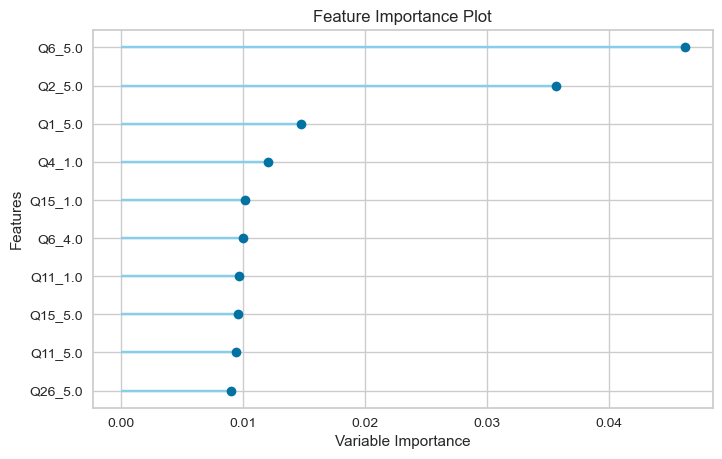

In [35]:
plot_model(model_xgb, plot='feature')

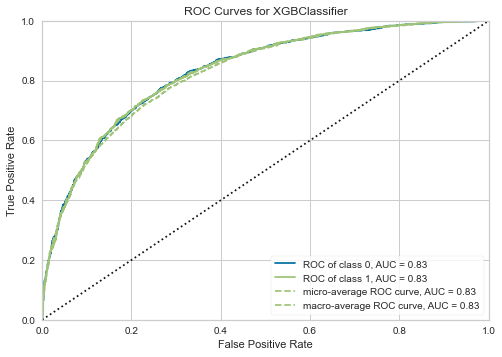

In [36]:
plot_model(model_xgb, plot='auc')

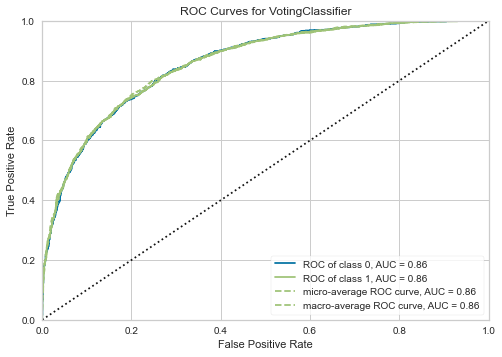

In [41]:
plot_model(blender_top5, plot='auc')

## Prediction for Test data 

In [41]:
# for total models 
for model in total_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7723,0.8651,0.8314,0.7741,0.8017,0.5352,0.5371


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7703,0.8582,0.8260,0.7743,0.7993,0.5315,0.5331


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7440,0.8188,0.8067,0.7499,0.7773,0.4773,0.4790


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7343,0.7940,0.8110,0.7361,0.7717,0.4558,0.4589


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7483,0.8108,0.8146,0.7517,0.7819,0.4856,0.4878


In [42]:
# for tuned models 
for model in tuned_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7723,0.8651,0.8314,0.7741,0.8017,0.5352,0.5371


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7703,0.8582,0.8260,0.7743,0.7993,0.5315,0.5331


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7737,0.8357,0.8362,0.7734,0.8036,0.5375,0.5398


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7713,0.8351,0.8356,0.7707,0.8018,0.5326,0.5350


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7463,0.8237,0.8007,0.7557,0.7776,0.4830,0.4841


In [43]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7803,0.8585,0.8411,0.7796,0.8092,0.5513,0.5535


# 6. Saving Models

In [59]:
final_model = blender_top5 # you should fill out this 

In [60]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'Pycaret_noprocessing_'+filename
filename

'Pycaret_noprocessing_0805_23_51'

In [61]:
save_model(final_model,path+filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['education',
                                                             'urban', 'gender',
                                                             'engnat', 'hand',
                                                             'religion',
                                                             'orientation',
                                                             'voted', 'married',
                                                             'ASD'],
                                       display_types=False,
                                       features_todrop=['country'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['introelapse',
                                                           'testelapse',
                    